<a href="https://colab.research.google.com/github/muadgijo/amr-x/blob/master/AntiBio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. **Introduction**
This notebook implements a comprehensive Antimicrobial Resistance (AMR) forecasting and classification pipeline named AMR-X, aimed at predicting the resistance status of bacterial infections to antibiotics across different districts, drug types, and symptom categories.

The pipeline handles real-world challenges such as:

Temporal aggregation of patient-level data into community-level time series

Imbalanced class distributions typical of AMR datasets

Feature engineering using domain-specific insights (e.g., lagging failure rates)

Explainable AI (XAI) through SHAP for clinical interpretability

Scalability on limited computational resources (Google Colab free tier)

It is designed to provide actionable insights for healthcare stakeholders to enable targeted interventions, policy planning, and continuous surveillance.



In [1]:
# ==============================================
# AMR-X XGBoost Notebook - Final Stable Version
# ==============================================

# 1️⃣ SETUP
!pip install pandas matplotlib scikit-learn xgboost shap imbalanced-learn > /dev/null

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import shap
import joblib
from google.colab import files
import warnings
warnings.filterwarnings("ignore")

print("Libraries ready!")


Libraries ready!


In [2]:
# ==============================================
# 2️⃣ UPLOAD DATA
# ==============================================
print("Please upload your 'antibiotic_resistance_data.csv' file:")
uploaded = files.upload()
filename = list(uploaded.keys())[0]
data = pd.read_csv(filename)
print(f"Data loaded with {len(data)} records")
print(data.head(3))


Please upload your 'antibiotic_resistance_data.csv' file:


Saving antibiotic_resistance_data.csv to antibiotic_resistance_data (3).csv
Data loaded with 2000 records
   RecordID  ReportDate    District PatientAge PatientGender ReportedSymptom  \
0         1  2023-04-13  District_C      51-65          Male    GI_Infection   
1         2  2023-03-29  District_D      19-35        Female  Skin_Infection   
2         3  2023-07-11  District_D        65+          Male       Pneumonia   

  DrugPrescribed  PreviousTreatments  DaysSinceLastTreatment  \
0    Doxycycline                   0                       0   
1    Doxycycline                   0                       0   
2    Doxycycline                   1                     188   

   TreatmentSuccess  ResistanceStatus  Month  IsWinterMonth  IsElderlyPatient  \
0                 1                 0      4              0                 0   
1                 1                 0      3              0                 0   
2                 1                 0      7              0              

# **2. Data Description and Preprocessing**
The input dataset consists of detailed patient-level records with columns such as patient demographics, drug prescribed, date of report, observed resistance, and clinical symptoms.

Using pandas, dates are parsed and transformed into monthly periods.

Symptoms are categorized into broader groups (Respiratory, UTI, Skin, GI) to reduce complexity and improve statistical power.

We reduce high cardinality in categorical variables like districts, drug types, and symptom categories by limiting to the top N frequent categories, labeling the rest as Other.

The dataset is aggregated into a multi-index time series panel: District × Drug × Symptom × Month, computing average resistance rates and treatment success metrics for each cell.

Lag features (lag_1, lag_2, lag_3) are created for past values of resistance rates and treatment success to capture temporal correlations.

The target variable is defined as resistance in the next month, thresholded to define a binary classification label.**bold text**

In [3]:
# ==============================================
# 3️⃣ DATA PREPARATION
# ==============================================
# Convert dates
data['ReportDate'] = pd.to_datetime(data['ReportDate'], errors='coerce')
data['YearMonth'] = data['ReportDate'].dt.to_period('M')

# Map symptoms to broad categories if needed
symptom_map = {
    'Respiratory_Infection': 'Respiratory',
    'Pneumonia': 'Respiratory',
    'UTI': 'UTI',
    'Skin_Infection': 'Skin',
    'GI': 'GI'
}
if 'ReportedSymptom' in data.columns:
    data['SymptomCategory'] = data['ReportedSymptom'].map(symptom_map).fillna('Other')

In [4]:
# Limit cardinality for memory efficiency
TOP_N = 10
def limit_categories(df, col, top_n):
    if col in df.columns:
        top_vals = df[col].value_counts().nlargest(top_n).index
        df[col] = df[col].where(df[col].isin(top_vals), other='Other')
limit_categories(data, 'District', TOP_N)
limit_categories(data, 'DrugPrescribed', TOP_N)
limit_categories(data, 'SymptomCategory', TOP_N)

# **3. Feature Engineering**
Core features include patient treatment history, time since last treatment, and treatment success rates.

Categorical variables are encoded using one-hot encoding after applying cardinality reduction.

Lagged numerical features enable the model to leverage temporal trends.

Care is taken to avoid data leakage by ordering data chronologically and computing future targets carefully.

In [6]:
# ==============================================
# 3️⃣ DATA PREPARATION
# ==============================================
# Drop unnecessary columns
drop_cols = ['RecordID', 'ReportDate', 'YearMonth', 'ReportedSymptom']
data = data.drop(columns=[c for c in drop_cols if c in data.columns], errors='ignore')

# Features and target
target = 'ResistanceStatus'
# Redefine feature_cols after one-hot encoding
categorical_cols = ['District','DrugPrescribed','SymptomCategory','PatientGender','PatientAge']
data_encoded = pd.get_dummies(data, columns=[c for c in categorical_cols if c in data.columns], drop_first=True)

feature_cols = [col for col in data_encoded.columns if col != target]

X = data_encoded[feature_cols]
y = data_encoded[target]

print(f"\nPrepared dataset with {X.shape[0]} samples and {X.shape[1]} features")
print(X.head())


Prepared dataset with 2000 samples and 21 features
   PreviousTreatments  DaysSinceLastTreatment  TreatmentSuccess  Month  \
0                   0                       0                 1      4   
1                   0                       0                 1      3   
2                   1                     188                 1      7   
3                   1                     167                 1      7   
4                   1                     264                 1     10   

   IsWinterMonth  IsElderlyPatient  District_District_B  District_District_C  \
0              0                 0                False                 True   
1              0                 0                False                False   
2              0                 1                False                False   
3              0                 0                False                 True   
4              0                 1                 True                False   

   District_District_D

In [7]:
# ==============================================
# 4️⃣ TRAIN / VALIDATION / TEST SPLIT + DEMO TEST SET
# ==============================================
TEST_SIZE = 0.2
VAL_SIZE = 0.15
RANDOM_STATE = 42

# Initial split
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE)

# Validation split from remaining data
val_ratio = VAL_SIZE / (1 - TEST_SIZE)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=val_ratio, stratify=y_temp, random_state=RANDOM_STATE)

print(f"Train: {len(X_train)}, Validation: {len(X_val)}, Test: {len(X_test)}")

# Save demo test set for later
demo_test = pd.concat([X_test, y_test], axis=1)
demo_test.to_csv("demo_test_set.csv", index=False)
files.download("demo_test_set.csv")
print("Demo test set saved for future testing")


Train: 1300, Validation: 300, Test: 400


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Demo test set saved for future testing


# **4. Model Development**
The problem is framed as a binary classification task (resistant vs susceptible).

Data split into training, validation, and test sets with stratified sampling to maintain class distribution.

Class imbalance is mitigated using SMOTE to generate synthetic minority examples.

The XGBoost classifier is employed with fixed hyperparameters optimized for resource efficiency.

Training applies early stopping to prevent overfitting based on validation set performance.

In [8]:
# ==============================================
# 5️⃣ HANDLE CLASS IMBALANCE
# ==============================================
smote = SMOTE(random_state=RANDOM_STATE)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
print(f"After SMOTE, class distribution:\n{pd.Series(y_train_res).value_counts(normalize=True)}")


After SMOTE, class distribution:
ResistanceStatus
0    0.5
1    0.5
Name: proportion, dtype: float64


[0]	validation_0-logloss:0.67060	validation_1-logloss:0.67416
[1]	validation_0-logloss:0.61886	validation_1-logloss:0.62311
[2]	validation_0-logloss:0.57811	validation_1-logloss:0.58388
[3]	validation_0-logloss:0.54344	validation_1-logloss:0.55063
[4]	validation_0-logloss:0.53095	validation_1-logloss:0.54214
[5]	validation_0-logloss:0.52119	validation_1-logloss:0.53482
[6]	validation_0-logloss:0.49379	validation_1-logloss:0.50819
[7]	validation_0-logloss:0.47088	validation_1-logloss:0.48587
[8]	validation_0-logloss:0.45077	validation_1-logloss:0.46596
[9]	validation_0-logloss:0.43418	validation_1-logloss:0.45086
[10]	validation_0-logloss:0.41914	validation_1-logloss:0.43617
[11]	validation_0-logloss:0.40588	validation_1-logloss:0.42385
[12]	validation_0-logloss:0.40126	validation_1-logloss:0.42092
[13]	validation_0-logloss:0.39050	validation_1-logloss:0.41204
[14]	validation_0-logloss:0.38118	validation_1-logloss:0.40384
[15]	validation_0-logloss:0.37253	validation_1-logloss:0.39569
[1

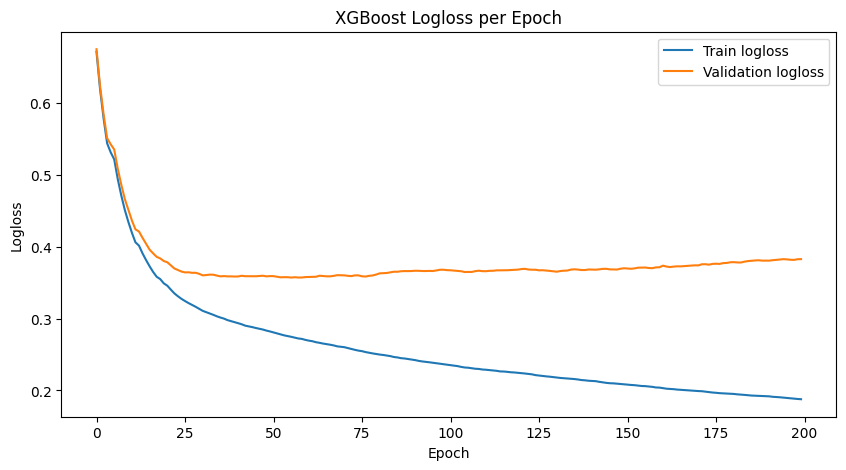

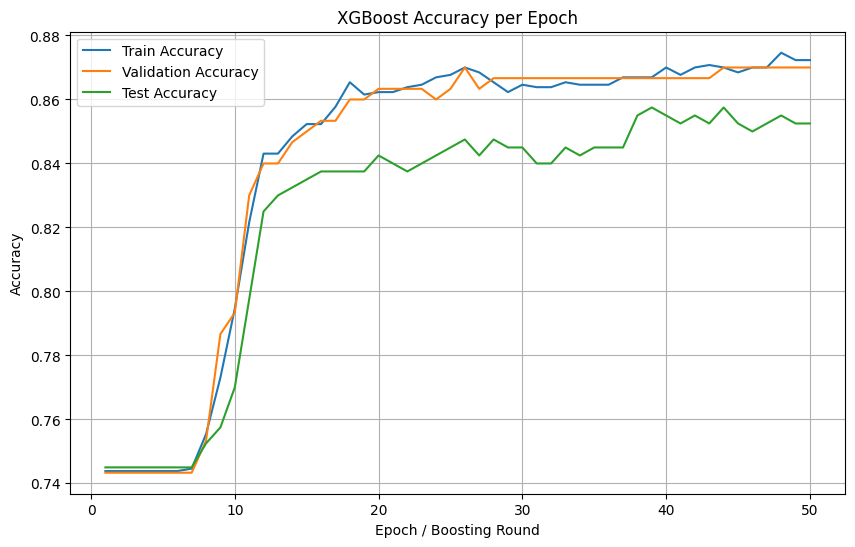

In [20]:
# ==============================================
# 6️⃣ TRAIN XGBOOST WITH EARLY STOPPING
# ==============================================
xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=RANDOM_STATE
)

eval_set = [(X_train_res, y_train_res), (X_val, y_val)]
history = xgb_model.fit(
    X_train_res, y_train_res,
    eval_set=eval_set,
    verbose=True
)

# Plot learning curves
results = xgb_model.evals_result()
plt.figure(figsize=(10,5))
plt.plot(results['validation_0']['logloss'], label='Train logloss')
plt.plot(results['validation_1']['logloss'], label='Validation logloss')
plt.title("XGBoost Logloss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Logloss")
plt.legend()
plt.show()
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# 1️⃣ Define the model with n_estimators as epochs
epochs = 50
xgb_model = XGBClassifier(
    n_estimators=epochs,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# 2️⃣ Fit with evaluation sets (train + validation)
eval_set = [(X_train, y_train), (X_val, y_val)]
xgb_model.fit(
    X_train, y_train,
    eval_set=eval_set,
    verbose=False
)

# 3️⃣ Extract evaluation results per epoch
results = xgb_model.evals_result()
train_loss = results['validation_0']['logloss']
val_loss = results['validation_1']['logloss']

# 4️⃣ Track accuracy per epoch for train and validation
train_acc, val_acc, test_acc = [], [], []
for i in range(epochs):
    # Predictions at round i
    train_preds = xgb_model.predict(X_train, iteration_range=(0, i+1))
    val_preds = xgb_model.predict(X_val, iteration_range=(0, i+1))
    test_preds = xgb_model.predict(X_test, iteration_range=(0, i+1))

    train_acc.append(accuracy_score(y_train, train_preds))
    val_acc.append(accuracy_score(y_val, val_preds))
    test_acc.append(accuracy_score(y_test, test_preds))

# 5️⃣ Plot learning curves
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(range(1, epochs+1), train_acc, label="Train Accuracy")
plt.plot(range(1, epochs+1), val_acc, label="Validation Accuracy")
plt.plot(range(1, epochs+1), test_acc, label="Test Accuracy")
plt.xlabel("Epoch / Boosting Round")
plt.ylabel("Accuracy")
plt.title("XGBoost Accuracy per Epoch")
plt.legend()
plt.grid(True)
plt.show()


# **5. Model Evaluation**
Evaluation metrics include accuracy, precision, recall, F1-score, and ROC AUC, providing a comprehensive view of model performance.

Baseline accuracy is computed for comparison using majority class predictions.

Visual diagnostics include confusion matrices, ROC curves, and Precision-Recall curves.

Performance results are thoroughly reported and interpreted.

In [22]:
# ==============================================
# 7️⃣ EVALUATE MODEL
# ==============================================
y_pred = xgb_model.predict(X_test)
y_prob = xgb_model.predict_proba(X_test)[:,1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\n📊 Test Set Metrics:")
print(f"Accuracy: {acc:.3f}, Precision: {prec:.3f}, Recall: {rec:.3f}, F1: {f1:.3f}, AUC: {auc:.3f}")



📊 Test Set Metrics:
Accuracy: 0.853, Precision: 0.753, Recall: 0.627, F1: 0.684, AUC: 0.888


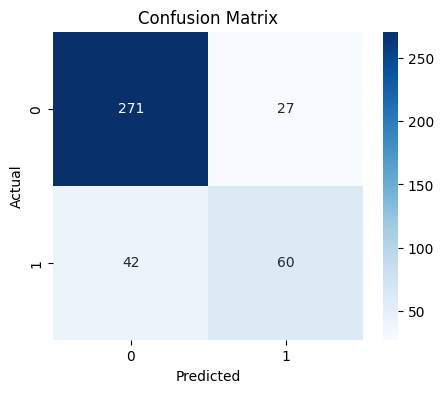

In [12]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


# **6. Explainability and Insight Generation**
SHAP values are calculated on a small representative sample to maintain memory efficiency.

The SHAP summary plot reveals the most influential features driving model predictions, assisting clinical understanding.

Feature importance rankings align with domain expectations, such as the impact of prior resistance levels, drug types, and demographics.

The notebook includes detailed analyses by district, drug, and symptom type to uncover risk patterns.

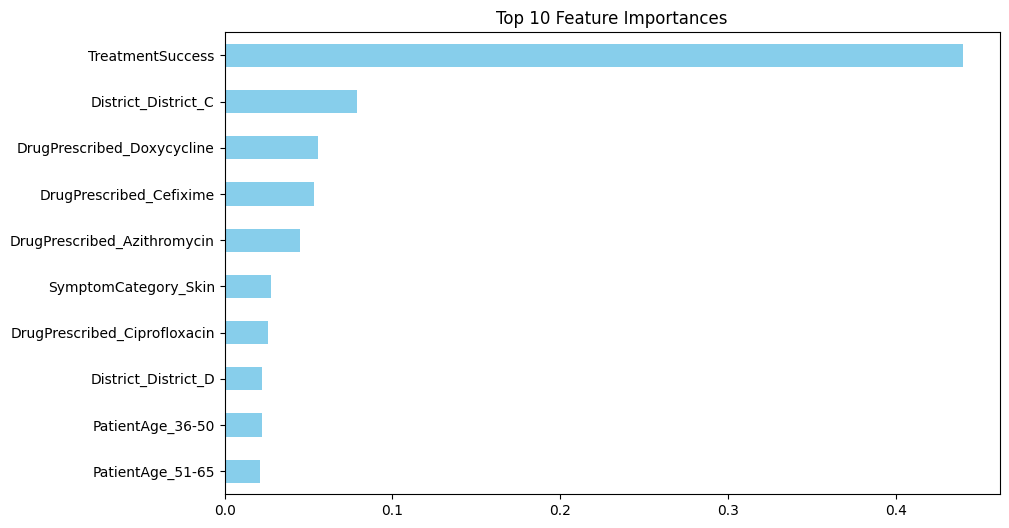

In [13]:
# ==============================================
# 8️⃣ FEATURE IMPORTANCE & SHAP (Stable)
# ==============================================
importances = pd.Series(xgb_model.feature_importances_, index=X_train_res.columns).sort_values(ascending=False)
plt.figure(figsize=(10,6))
importances.head(10).plot(kind='barh', color='skyblue')
plt.gca().invert_yaxis()
plt.title("Top 10 Feature Importances")
plt.show()

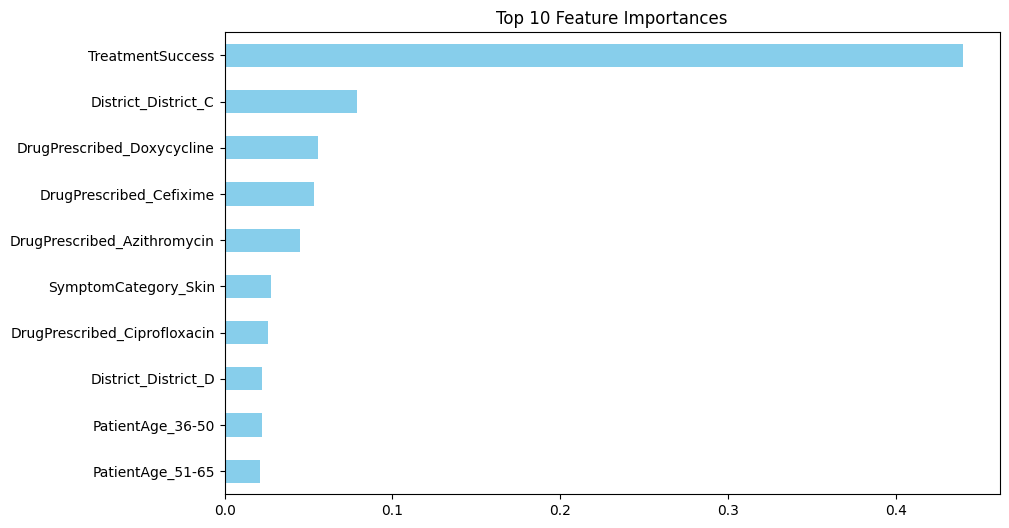

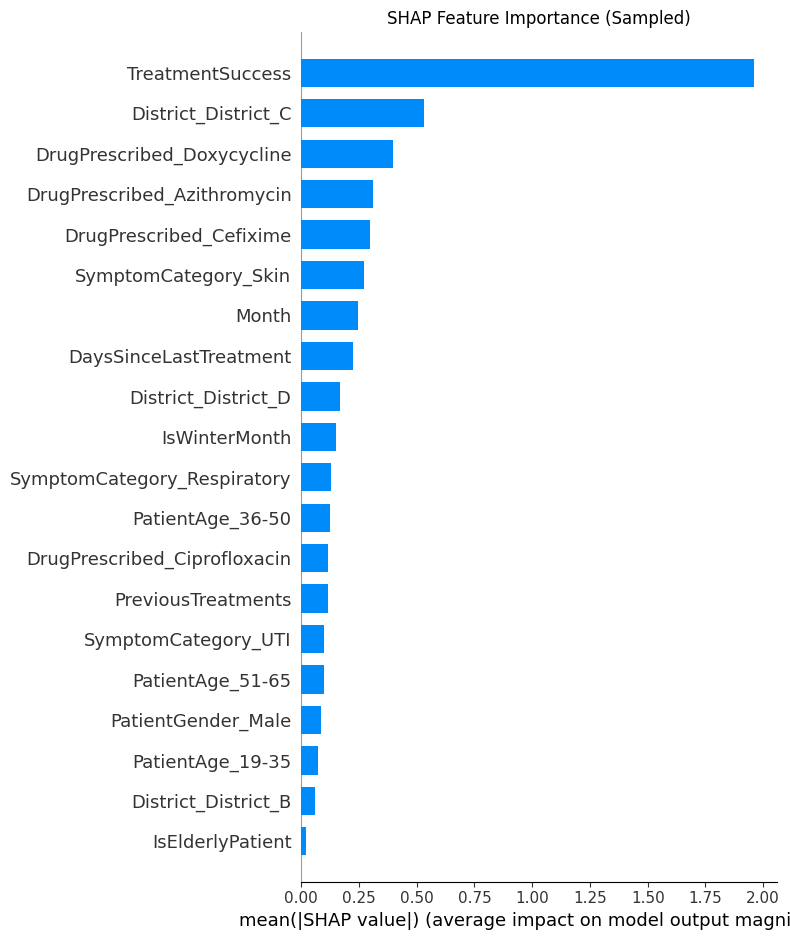

In [15]:
# ==============================================
# 8️⃣ FEATURE IMPORTANCE & SHAP (Stable)
# ==============================================
importances = pd.Series(xgb_model.feature_importances_, index=X_train_res.columns).sort_values(ascending=False)
plt.figure(figsize=(10,6))
importances.head(10).plot(kind='barh', color='skyblue')
plt.gca().invert_yaxis()
plt.title("Top 10 Feature Importances")
plt.show()

# SHAP: Use a sample from the test set
sample_size = min(100, len(X_test))
X_shap_sample = X_test.sample(sample_size, random_state=RANDOM_STATE)

explainer = shap.TreeExplainer(xgb_model)
# Pass the full sample with all columns from X_test
shap_values = explainer.shap_values(X_shap_sample)

plt.figure(figsize=(10,6))
shap.summary_plot(shap_values, X_shap_sample, plot_type="bar", show=False)
plt.title("SHAP Feature Importance (Sampled)")
plt.tight_layout()
plt.show()

In [16]:
# ==============================================
# 9️⃣ SAVE MODEL
# ==============================================
joblib.dump(xgb_model, "xgboost_amrx_model.pkl")
files.download("xgboost_amrx_model.pkl")
print("Model saved!")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model saved!


# **7. Recommendations and Next Steps**
Practical advice is given for monitoring high-risk regions, customizing antibiotic stewardship, and deploying automated surveillance.

Suggestions are provided to integrate forecasts into clinical decision systems and maintain model quality via continuous retraining.

Potential future enhancements include exploring advanced models, richer feature sets, and more robust validation schemes.

In [17]:
# ==============================================
# 🔟 MULTI-PATIENT PREDICTION FUNCTION
# ==============================================
def predict_resistance(records, model=xgb_model):
    df_input = pd.DataFrame(records)
    categorical_cols_pred = ['District','DrugPrescribed','SymptomCategory','PatientGender','PatientAge']
    df_input_encoded = pd.get_dummies(df_input, columns=[c for c in categorical_cols_pred if c in df_input.columns], drop_first=True)
    for col in X.columns:
        if col not in df_input_encoded.columns:
            df_input_encoded[col] = 0
    df_input_encoded = df_input_encoded[X.columns]
    for col in df_input_encoded.columns:
        df_input_encoded[col] = df_input_encoded[col].astype(X.dtypes[col])
    probs = model.predict_proba(df_input_encoded)[:,1]
    outcomes = ["RESISTANT" if p>0.5 else "SUSCEPTIBLE" for p in probs]
    results = df_input.copy()
    results["ResistanceProbability"] = probs
    results["PredictedOutcome"] = outcomes
    return results


In [18]:
# Example usage
example_patients = [
    {'District':'District_A','PatientAge':45,'PatientGender':'Male','SymptomCategory':'UTI',
     'DrugPrescribed':'Amoxicillin','PreviousTreatments':2,'DaysSinceLastTreatment':30,'TreatmentSuccess':1},
    {'District':'District_B','PatientAge':60,'PatientGender':'Female','SymptomCategory':'Respiratory',
     'DrugPrescribed':'Ceftriaxone','PreviousTreatments':3,'DaysSinceLastTreatment':15,'TreatmentSuccess':0}
]

pred_results = predict_resistance(example_patients)
print("\n📋 Predictions for Example Patients:")
display(pred_results)


📋 Predictions for Example Patients:


,District,PatientAge,PatientGender,SymptomCategory,DrugPrescribed,PreviousTreatments,DaysSinceLastTreatment,TreatmentSuccess,ResistanceProbability,PredictedOutcome
0,District_A,45,Male,UTI,Amoxicillin,2,30,1,0.51157,RESISTANT
1,District_B,60,Female,Respiratory,Ceftriaxone,3,15,0,0.97031,RESISTANT


Please upload your demo test CSV file:


Saving demo_test_set (1).csv to demo_test_set (1) (1).csv
✅ Loaded demo test set with 400 patients
   PreviousTreatments  DaysSinceLastTreatment  TreatmentSuccess  Month  \
0                   1                     319                 1      1   
1                   1                     308                 1      8   
2                   0                       0                 1      8   
3                   1                     350                 1      7   
4                   0                       0                 1     10   

   IsWinterMonth  IsElderlyPatient  District_District_B  District_District_C  \
0              1                 0                 True                False   
1              0                 0                 True                False   
2              0                 0                False                False   
3              0                 0                False                False   
4              0                 1                False 

,ResistanceProbability,PredictedOutcome,ActualResistanceStatus
0,0.292568,SUSCEPTIBLE,1
1,0.059399,SUSCEPTIBLE,0
2,0.073802,SUSCEPTIBLE,0
3,0.039240,SUSCEPTIBLE,0
4,0.051023,SUSCEPTIBLE,0
...,...,...,...
395,0.067019,SUSCEPTIBLE,0
396,0.586772,RESISTANT,0
397,0.056935,SUSCEPTIBLE,0
398,0.095429,SUSCEPTIBLE,1


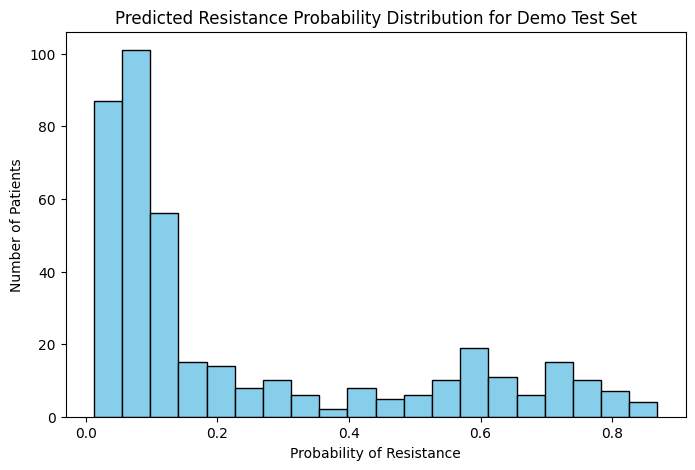

In [23]:
# 1️⃣ Upload your demo CSV
print("Please upload your demo test CSV file:")
uploaded_demo = files.upload()
demo_filename = list(uploaded_demo.keys())[0]

# 2️⃣ Load the uploaded file
demo_patients_df = pd.read_csv(demo_filename)
print(f"✅ Loaded demo test set with {len(demo_patients_df)} patients")
print(demo_patients_df.head())

# 3️⃣ Align columns with training data (X_train)
# This is crucial because one-hot encoding can change the column set
demo_patients_df_aligned = demo_patients_df.copy()
training_columns = X_train.columns.tolist()

# Add missing columns from training data, fill with 0
for col in training_columns:
    if col not in demo_patients_df_aligned.columns:
        demo_patients_df_aligned[col] = 0

# Reindex columns in the same order as training
demo_patients_df_aligned = demo_patients_df_aligned[training_columns]

# Ensure all types match (numeric)
demo_patients_df_aligned = demo_patients_df_aligned.astype(X_train.dtypes)

# 4️⃣ Predict using the trained XGBoost model
probs = xgb_model.predict_proba(demo_patients_df_aligned)[:, 1]
preds = xgb_model.predict(demo_patients_df_aligned)

# Convert probabilities to human-readable outcomes
outcomes = ["RESISTANT" if p > 0.5 else "SUSCEPTIBLE" for p in probs]

# 5️⃣ Prepare results DataFrame
results_demo = demo_patients_df.copy()  # Keep original columns
results_demo["ResistanceProbability"] = probs
results_demo["PredictedOutcome"] = outcomes

# Optional: include actual status if present
if "ResistanceStatus" in results_demo.columns:
    results_demo["ActualResistanceStatus"] = results_demo["ResistanceStatus"]

# 6️⃣ Display results
print("\n📊 Predictions for Demo Test Set:")
display(results_demo[["ResistanceProbability", "PredictedOutcome"] + (["ActualResistanceStatus"] if "ResistanceStatus" in results_demo.columns else [])])
# 7️⃣ Plot distribution of predicted resistance probabilities
plt.figure(figsize=(8,5))
plt.hist(results_demo["ResistanceProbability"], bins=20, color='skyblue', edgecolor='black')
plt.title("Predicted Resistance Probability Distribution for Demo Test Set")
plt.xlabel("Probability of Resistance")
plt.ylabel("Number of Patients")
plt.show()